# 1) Setup env, MinIO client, Chroma client

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
import boto3
from botocore.config import Config
from typing import Dict, Any
from PIL import Image
import torch
import open_clip
from PIL import Image
from typing import Dict, Any
from PIL import Image
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction, SentenceTransformerEmbeddingFunction

dotenv_path = find_dotenv(filename='.env', usecwd=True)
if not dotenv_path:
    raise FileNotFoundError("Could not find .env. Set its path manually.")
print(f"Loading environment variables from {dotenv_path}")
load_dotenv(dotenv_path)

# --- ENV ---
TRUSTED_BUCKET       = os.environ.get("TRUSTED_BUCKET", "trusted-zone")

CHROMA_PERSIST_DIR   = os.environ.get("CHROMA_PERSIST_DIR", "exploitation_zone/chroma")

# --- MinIO S3 client ---
MINIO_USER     = os.environ.get("MINIO_USER")
MINIO_PASSWORD = os.environ.get("MINIO_PASSWORD")
MINIO_ENDPOINT = os.environ.get("MINIO_ENDPOINT")

session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

# --- Chroma client ---
CHROMA = PersistentClient(path="../" + CHROMA_PERSIST_DIR)

/Users/dcayuela/Desktop/UPC/ADSDB/project/adsdb-multimodal-food-data-management/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading environment variables from /Users/dcayuela/Desktop/UPC/ADSDB/project/adsdb-multimodal-food-data-management/notebooks/.env


In [2]:
# Test MinIO connection and bucket
try:
    # List all buckets
    response = s3.list_buckets()
    print("Available buckets:", [b['Name'] for b in response['Buckets']])
    
    # Check if trusted-zone bucket exists
    if TRUSTED_BUCKET in [b['Name'] for b in response['Buckets']]:
        print(f"✅ Bucket '{TRUSTED_BUCKET}' exists")
    else:
        print(f"❌ Bucket '{TRUSTED_BUCKET}' does NOT exist")
        
    # Try to list objects in the bucket
    try:
        objects = s3.list_objects_v2(Bucket=TRUSTED_BUCKET)
        print(f"Objects in {TRUSTED_BUCKET}: {objects.get('KeyCount', 0)}")
    except Exception as e:
        print(f"Cannot access bucket {TRUSTED_BUCKET}: {e}")
        
except Exception as e:
    print(f"MinIO error: {e}")

Available buckets: ['exploitation-zone', 'formatted-zone', 'landing-zone', 'trusted-zone']
✅ Bucket 'trusted-zone' exists
Objects in trusted-zone: 49


# 2) Retrieval helpers 


In [3]:
_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Match Chroma's default OpenCLIPEmbeddingFunction() config
_MODEL_NAME = "ViT-B-32"
_PRETRAINED = "laion2b_s34b_b79k"

_CLIP_MODEL, _CLIP_PREPROCESS, _ = open_clip.create_model_and_transforms(
    _MODEL_NAME,
    pretrained=_PRETRAINED,
    device=_DEVICE
)

@torch.no_grad()
def encode_image_to_vec(pil_img: Image.Image) -> list[float]:
    """
    Produce an OpenCLIP image embedding compatible with the vectors stored in
    the 'trusted_zone_images' Chroma collection.
    """
    img_tensor = _CLIP_PREPROCESS(pil_img).unsqueeze(0).to(_DEVICE)
    img_features = _CLIP_MODEL.encode_image(img_tensor)
    img_features = img_features / img_features.norm(dim=-1, keepdim=True)
    return img_features.squeeze(0).cpu().tolist()

import io
import matplotlib.pyplot as plt

def show_retrieved_images(local_query_path, hits):
    """Show the query image followed by the retrieved similar images."""
    # --- display the query image ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, len(hits) + 1, 1)
    query_img = Image.open(local_query_path).convert("RGB")
    plt.imshow(query_img)
    plt.axis("off")
    plt.title("Query")

    # --- display each retrieved image from MinIO ---
    for i, hit in enumerate(hits, start=2):
        bucket = hit["image_s3_bucket"]
        key = hit["image_s3_key"]
        score = hit["score"]

        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read())).convert("RGB")

        plt.subplot(1, len(hits) + 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{i-1}. Distance={score:.3f}", fontsize=8)

    plt.tight_layout()
    plt.show()

import textwrap

def show_text_results(result):
    print(f"🔎 Query: {result['query']}\n")
    for i, hit in enumerate(result["hits"], start=1):
        text_preview = textwrap.shorten(hit["text"], width=180, placeholder="…")
        print(f"{i}.  Distance={hit['score']:.3f}")
        print(text_preview)
        print("-" * 80)



In [4]:
ef_img = OpenCLIPEmbeddingFunction()
ef_text = SentenceTransformerEmbeddingFunction(model_name="Qwen/Qwen3-Embedding-0.6B")

def get_text_collection():
    return CHROMA.get_collection(
        name="trusted_zone_documents",
        embedding_function=ef_text,
    )

def get_image_collection():
    return CHROMA.get_collection(
        name="trusted_zone_images",
        embedding_function=ef_img,
    )

def retrieve_text(query: str, k: int = 5) -> Dict[str, Any]:
    """
    Retrieve top-k similar text docs from Chroma for a given natural language query.
    Returns a dict with 'hits' = [{text, meta, score}, ...]
    """
    col = get_text_collection()

    result = col.query(
        query_texts=[query],
        n_results=k,
        include=["documents", "metadatas", "distances"],
    )
    
    hits = []
    docs = result.get("documents", [[]])[0]
    metas = result.get("metadatas", [[]])[0]
    dists = result.get("distances", [[]])[0]

    for text_doc, meta, dist in zip(docs, metas, dists):
        hits.append({
            "text": text_doc,
            "meta": meta,
            "score": float(dist),
        })

    return {
        "query": query,
        "hits": hits,
    }

def retrieve_images(
    image_path: str,
    k: int = 5,
) -> Dict[str, Any]:
    """
    Retrieve top-k similar IMAGES from Chroma.
      image→image search:
         - image_path is provided
         - we take that local image, build its OpenCLIP IMAGE embedding
           using encode_image_to_vec(...)
         - then we pass that vector as query_embeddings=[...]
    """
    col = get_image_collection()

    pil_img = Image.open(image_path).convert("RGB")
    img_vec = encode_image_to_vec(pil_img)  # list[float]

    result = col.query(
        query_embeddings=[img_vec],
        n_results=k,
        include=["metadatas", "distances"],
    )

    metas = result.get("metadatas", [[]])[0]
    dists = result.get("distances", [[]])[0]

    hits = []
    for meta, dist in zip(metas, dists):
        hits.append({
            "image_s3_bucket": meta.get("bucket"),
            "image_s3_key": meta.get("object_key"),
            "score": float(dist),
        })

    return {"hits": hits}

In [5]:
# Debug: Check what collections exist
print("Available collections:")
for col_name in CHROMA.list_collections():
    print(f"  - {col_name.name}")
    
# Check the specific collection
try:
    col = CHROMA.get_collection("trusted_zone_documents")
    count = col.count()
    print(f"\nCollection 'trusted_zone_documents' has {count} documents")
    
    if count > 0:
        # Get a sample
        sample = col.get(limit=2)
        print("Sample documents:")
        for i, doc in enumerate(sample['documents'][:2]):
            print(f"[{i+1}] {doc[:200]}...")
except Exception as e:
    print(f"Error accessing collection: {e}")

Available collections:
  - trusted_zone_documents
  - trusted_zone_images
  - trusted_zone_multimodal

Collection 'trusted_zone_documents' has 35 documents
Sample documents:
[1] title: crunchy onion potato bake
ingredients: 2 12 cups milk 1 12 cups water 14 cup butter mashed potatoes 1 box homestyle 1 8 ounce whole kernel corn drained 1 cup cheddar cheese 1 cup french fried o...
[2] title: strawberry rhubarb dump cake
ingredients: 6 8 cups fresh rhubarb 6 8 cups frozen rhubarb thawed 1 12 cups granulated sugar 6 ounces strawberry jell gelatin dessert 1 white cake mix 2 layer size...


# 3) Image to image search


images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$fb5e74d207155ada179586fadfd41b4c__00034ad6cc_0.jpg → 0.37
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$2ae214acf9fa1e79658ea486f850525c__00034ad6cc_2.jpg → 0.426
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$85ae0f868eeaff2e38971c848cbe8d71__00034ad6cc_1.jpg → 0.454
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$97276ba02a887b528c09bd59dad3ce13__00082e1318_0.jpg → 0.471
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$bdce510ea0e1856b7ab1d508f9a126bd__00098bc4cc_0.jpg → 0.472


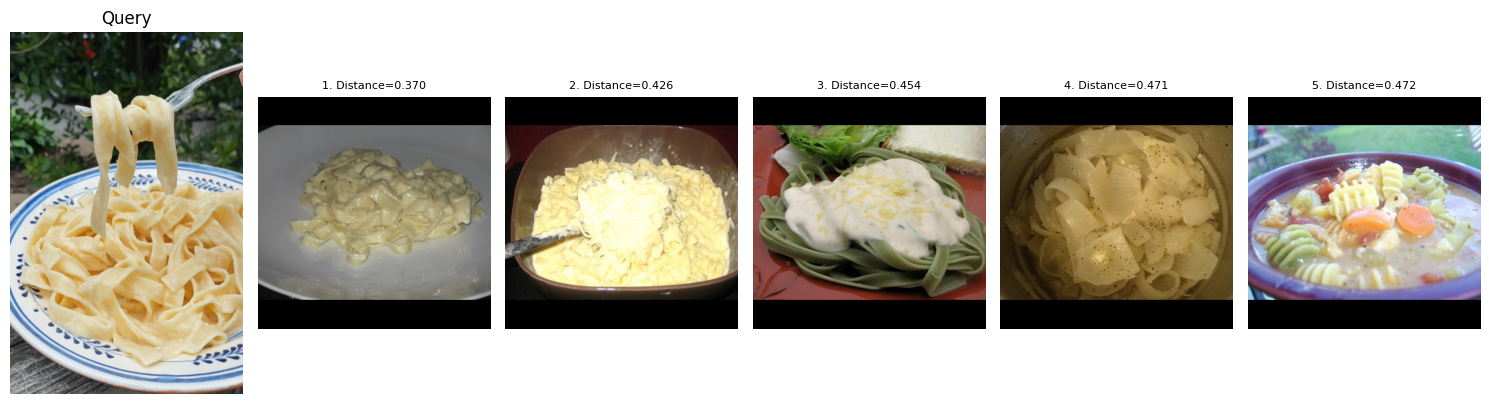

In [6]:
test_image_path = "fettuccine-alfredeo.jpg"  # example
result_images = retrieve_images(test_image_path, k=5)
result_images

hits = result_images["hits"]
for h in hits:
    print(h["image_s3_key"], "→", round(h["score"], 3))

show_retrieved_images(test_image_path, result_images["hits"])



images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$696e8155589b80eb0ec8cf18b083b669__0007a28fe7_0.jpg → 0.351
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$72b3e6e5ece452f537675217b7cc8fe1__00089c3010_0.jpg → 0.388
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$a4ceb432f1c35f0de4da866ab18b4656__00063fb14c_0.jpg → 0.397
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$aa96ee07545dc7c815d404942f3f28c7__00047059be_0.jpg → 0.411
images/image$adsdb-multimodal-food-data-management$2025-10-29T21-14-26Z$178c1af104b971fe99d70bfdaf0b9f10__00059b093b_0.jpg → 0.456


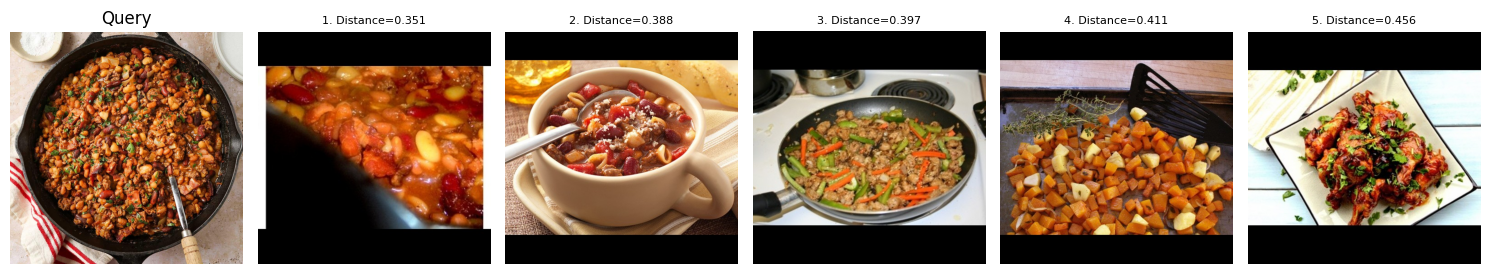

In [7]:
test_image_path = "calico-beans.jpg"  # example
result_images = retrieve_images(test_image_path, k=5)
result_images

hits = result_images["hits"]
for h in hits:
    print(h["image_s3_key"], "→", round(h["score"], 3))

show_retrieved_images(test_image_path, result_images["hits"])



# 4) Text to text search


In [8]:
query = "crunchy onion potato bake"
result_texts = retrieve_text(query, k=5)
show_text_results(result_texts)

🔎 Query: crunchy onion potato bake

1.  Distance=0.253
title: crunchy onion potato bake ingredients: 2 12 cups milk 1 12 cups water 14 cup butter mashed potatoes 1 box homestyle 1 8 ounce whole kernel corn drained 1 cup cheddar cheese…
--------------------------------------------------------------------------------
2.  Distance=0.287
title: shalom bayit kugel potato kugel ingredients: 10 lbs potatoes peeled 2 onions peeled 9 10 large eggs 7 8 extra large eggs 1 12 tablespoons salt 14 cup oil instructions:…
--------------------------------------------------------------------------------
3.  Distance=0.397
title: boiled onions ingredients: 2 lbs onions white yellow vidalia 1 tablespoon margarine use smart balance light 1 tablespoon butter 1 tablespoon sugar adjust according…
--------------------------------------------------------------------------------
4.  Distance=0.432
title: grandmommy mexicali meatloaf ingredients: 1 12 lbs ground beef 34 cup oats 12 cup tomato juice 1 egg 2 teaspo

In [9]:
query = "chicken noodle soup"
result_texts = retrieve_text(query, k=5)
show_text_results(result_texts)

🔎 Query: chicken noodle soup

1.  Distance=0.357
title: curly q noodle chicken soup ingredients: 1 lb boneless skinless chicken breast cut 1 2 inch pieces 1 large onion chopped 4 celery ribs sliced 2 medium carrots sliced 4…
--------------------------------------------------------------------------------
2.  Distance=0.422
title: spicy korean temple noodles ingredients: 2 tablespoons gochujang korean chile paste 2 tablespoons asian persimmon plum fruit vinegar 2 tablespoons sugar preferably organic…
--------------------------------------------------------------------------------
3.  Distance=0.467
title: grandmommy mexicali meatloaf ingredients: 1 12 lbs ground beef 34 cup oats 12 cup tomato juice 1 egg 2 teaspoons salt 14 teaspoon pepper 1 teaspoon chili powder 2 teaspoons…
--------------------------------------------------------------------------------
4.  Distance=0.490
title: chicken sausage stir fry ingredients: 3 chicken sausage 1 garlic clove crushed 1 large onion chopped 1 larg